<a href="https://colab.research.google.com/github/ortymid/lungs-image-segmentation/blob/master/lungs_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import shutil
from pathlib import Path
import random

from google.colab import drive

import cv2
import numpy as np 
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

#### Пути к файлам

In [0]:
DRIVE_PATH = Path('/content/drive')
DATASET_ARCHIVE_PATH = DRIVE_PATH / 'My Drive' / 'Colab Notebooks' / 'data' / 'dataset.tar.gz'  # путь к архиву на драйве, 
                                                                                                # имя архива оставить "dataset"

DATASET_PATH = Path('/content/dataset')  # предполагается, что имя архива было "dataset"
ALL_IMAGES_PATH = DATASET_PATH / 'images'
ALL_MASKS_PATH = DATASET_PATH / 'masks'

#### Получение и распаковка данных

In [47]:
drive.mount(DRIVE_PATH.as_posix())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!tar -xzf '{DATASET_ARCHIVE_PATH}'

In [0]:
def mask_path(image_path: Path) -> Path:
  mask_name = image_path.stem + '_mask'
  return ALL_MASKS_PATH / (mask_name + image_path.suffix)

In [0]:
all_images = list(ALL_IMAGES_PATH.iterdir())
all_masks = list(ALL_MASKS_PATH.iterdir())

# не всем изображениям сооветсвует маска, поэтому фильтруем по названию 
images_with_mask = [img_path 
                    for img_path in all_images 
                    if mask_path(img_path) in all_masks]

#### Получение train, validation и test выборок

In [0]:
random.seed(8996)
random.shuffle(images_with_mask)

train_split = int(len(images_with_mask) * 0.7)
val_split = int(len(images_with_mask) * 0.9)

train_images = images_with_mask[:train_split]
val_images = images_with_mask[train_split:val_split]
test_images = images_with_mask[val_split:]

train_masks = [mask_path(p) for p in train_images]
val_masks = [mask_path(p) for p in val_images]
test_masks = [mask_path(p) for p in test_images]

In [0]:
def copy_path_list(path_list: list, dst_dir: Path) -> None:
  if not dst_dir.exists():
    os.makedirs(dst_dir)
  for path in path_list:
    shutil.copy(path, dst_dir / path.name)

In [0]:
copy_path_list(train_images, DATASET_PATH / 'train_images')
copy_path_list(val_images, DATASET_PATH / 'val_images')
copy_path_list(test_images, DATASET_PATH / 'test_images')

copy_path_list(train_masks, DATASET_PATH / 'train_masks')
copy_path_list(val_masks, DATASET_PATH / 'val_masks')
copy_path_list(test_masks, DATASET_PATH / 'test_masks')

#### Обучение

In [0]:
NUM_TRAIN_IMAGES = len(train_images)
NUM_VAL_IMAGES = len(val_images)
NUM_EPOCHS = 12 # не предел, но даёт более-менее точность относительно времени ожидания
BATCH_SIZE = 16 # 32 не влазит в память

WEIGHTS_PATH = DATA_PATH / 'weights'

In [0]:
def data_gen(img_dir: Path, mask_dir: Path, batch_size: int, target_size=(256, 256)) -> (list, list):
  images = list(img_dir.iterdir())
  random.shuffle(images)
  
  count = 0
  while True:
    img = np.zeros((batch_size, *target_size, 1)).astype('float')
    mask = np.zeros((batch_size, *target_size, 1)).astype('float')
    
    for i in range(count, count + batch_size):
      train_img = cv2.imread(images[i].as_posix(), cv2.IMREAD_GRAYSCALE) / 255.
      train_img = cv2.resize(train_img, target_size)    
      train_img = train_img.reshape(*target_size, 1)
      
      img[i - count] = train_img
      
      train_mask = cv2.imread(mask_path(images[i]).as_posix(), cv2.IMREAD_GRAYSCALE) / 255.
      train_mask = cv2.resize(train_mask, target_size)
      train_mask = train_mask.reshape(*target_size, 1)

      mask[i - count] = train_mask
      
    count += batch_size
    if count + batch_size >= len(images):
      count = 0
      random.shuffle(images)
      
    yield img, mask

#### Первая попытка
Можно пропустить, оставил на всякий случай. Встроенный генератор данных делал странную трансформацию изображений, поэтому было принято решение использовать самописный (что быстрее, чем разбираться).

In [0]:
# train_datagen = ImageDataGenerator(rescale=1./255)
# val_datagen = ImageDataGenerator(rescale=1./255)

# train_image_generator = train_datagen.flow_from_directory(DATASET_PATH / 'train_images', class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE)
# train_mask_generator = train_datagen.flow_from_directory(DATASET_PATH / 'train_masks', class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE)

# val_image_generator = val_datagen.flow_from_directory(DATASET_PATH / 'val_images', class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE)
# val_mask_generator = val_datagen.flow_from_directory(DATASET_PATH / 'val_masks', class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE)

# train_generator = zip(train_image_generator, train_mask_generator)
# val_generator = zip(val_image_generator, val_mask_generator)

In [0]:
# def unet(pretrained_weights = None, input_size = (256,256,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(input = inputs, output = conv10)

#     model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     # model.summary()

#     if (pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model

#### Вторая попытка

In [0]:
def unet2():
  inputs = Input((256, 256, 1))
  
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  
  return model

In [0]:
model = unet2()

In [60]:
model.fit_generator(data_gen(DATASET_PATH / 'train_images', DATASET_PATH / 'train_masks', BATCH_SIZE), 
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE,
                    validation_data=data_gen(DATASET_PATH / 'val_images', DATASET_PATH / 'val_masks', BATCH_SIZE),
                    validation_steps=NUM_VAL_IMAGES // BATCH_SIZE)

model.save('lungs_weights.h5')

Epoch 1/12
24/24 [==============================] - 81s 3s/step - loss: 0.6055 - acc: 0.6950 - val_loss: 0.5511 - val_acc: 0.7421
Epoch 2/12
24/24 [==============================] - 72s 3s/step - loss: 0.5428 - acc: 0.7194 - val_loss: 0.5759 - val_acc: 0.7471
Epoch 3/12
24/24 [==============================] - 71s 3s/step - loss: 0.5593 - acc: 0.7414 - val_loss: 0.4270 - val_acc: 0.7404
Epoch 4/12
24/24 [==============================] - 71s 3s/step - loss: 0.5183 - acc: 0.7503 - val_loss: 0.4338 - val_acc: 0.7420
Epoch 5/12
24/24 [==============================] - 70s 3s/step - loss: 0.3952 - acc: 0.8050 - val_loss: 0.6765 - val_acc: 0.7868
Epoch 6/12
24/24 [==============================] - 71s 3s/step - loss: 0.2256 - acc: 0.9104 - val_loss: 0.2280 - val_acc: 0.9045
Epoch 7/12
24/24 [==============================] - 71s 3s/step - loss: 0.1605 - acc: 0.9387 - val_loss: 0.2992 - val_acc: 0.9223
Epoch 8/12
24/24 [==============================] - 71s 3s/step - loss: 0.1266 - acc: 0.95

#### Тестирование

In [0]:
test_images, test_masks = next(data_gen(DATASET_PATH / 'test_images', DATASET_PATH / 'test_masks', 16))

In [0]:
res = model.predict(test_images)

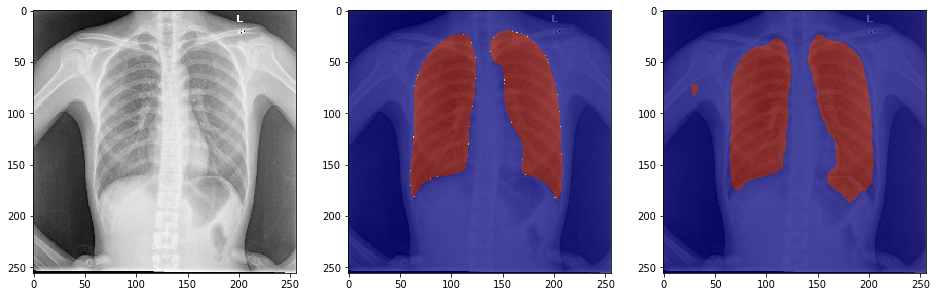

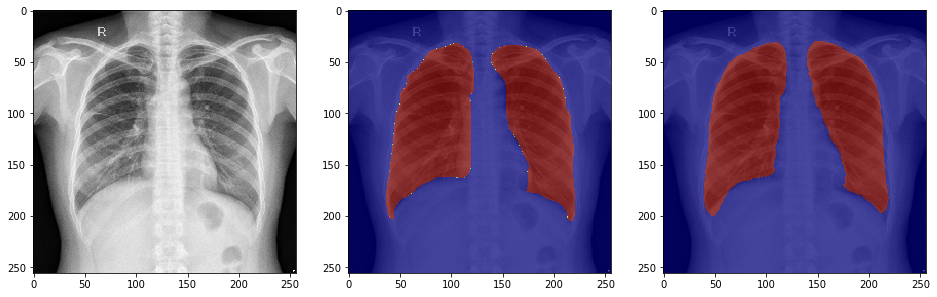

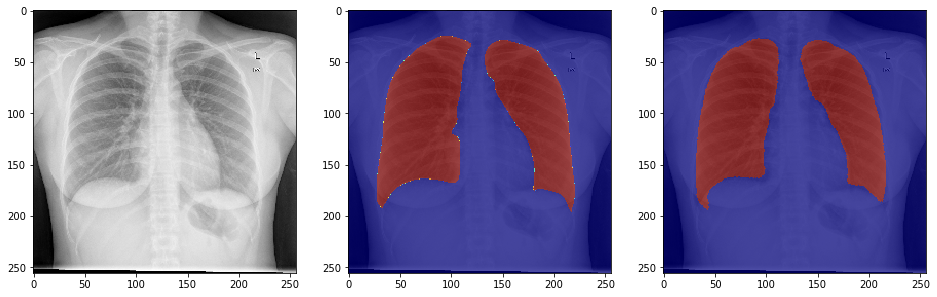

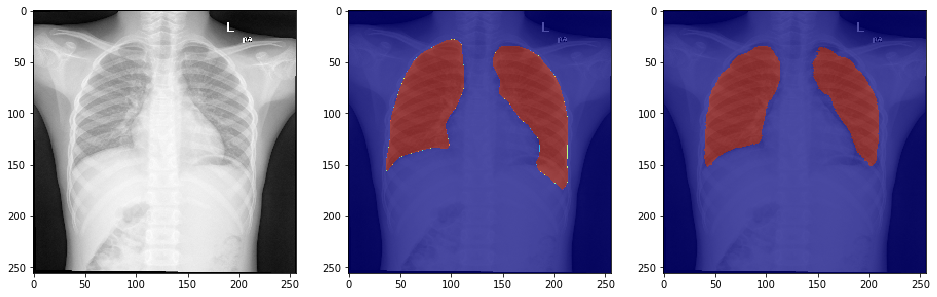

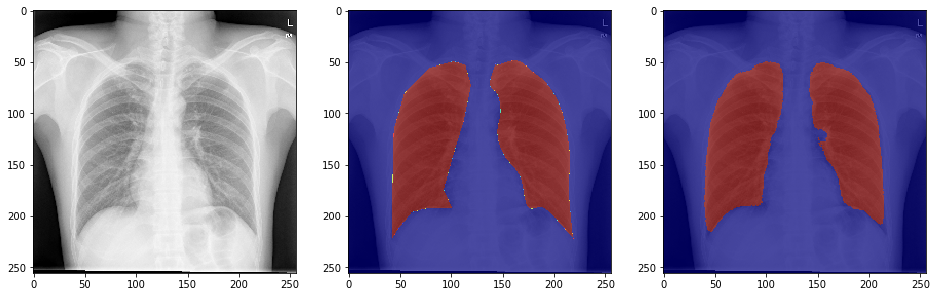

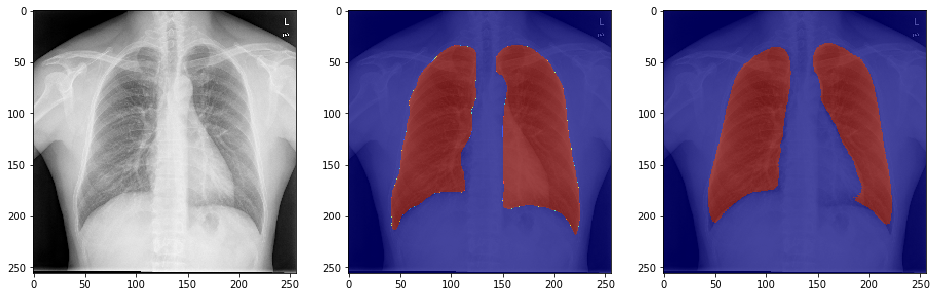

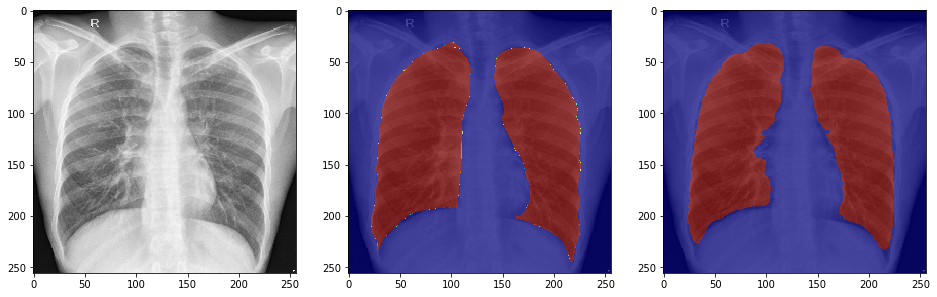

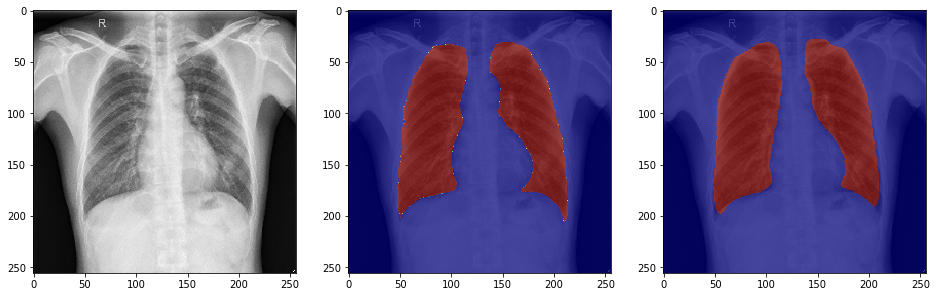

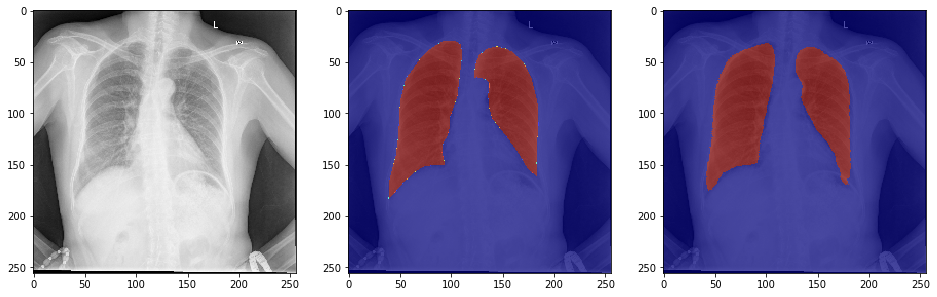

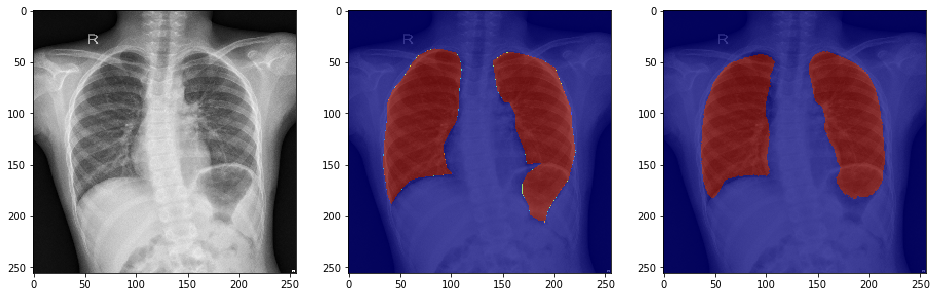

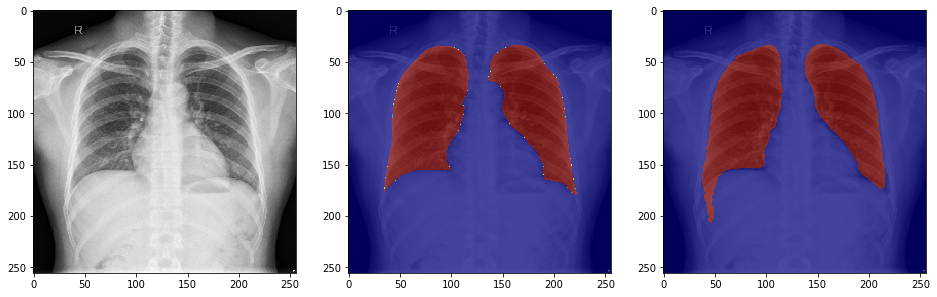

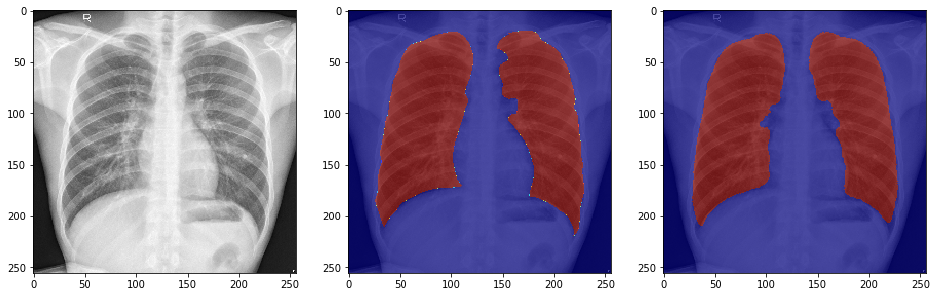

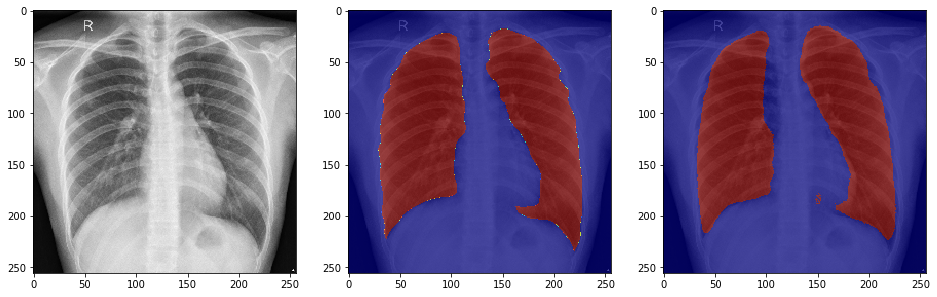

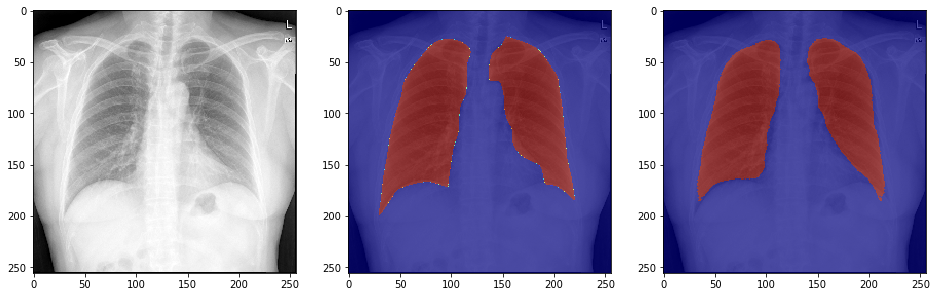

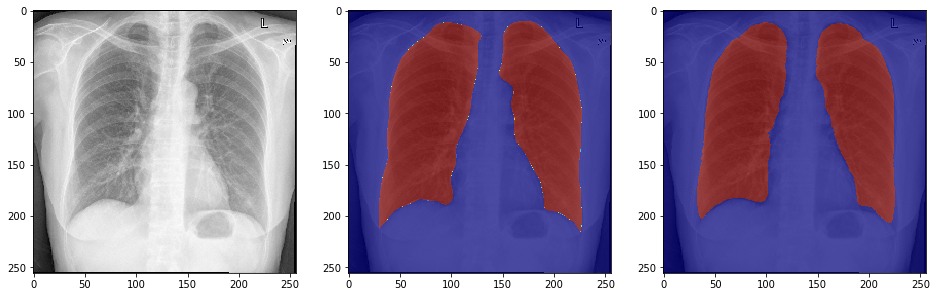

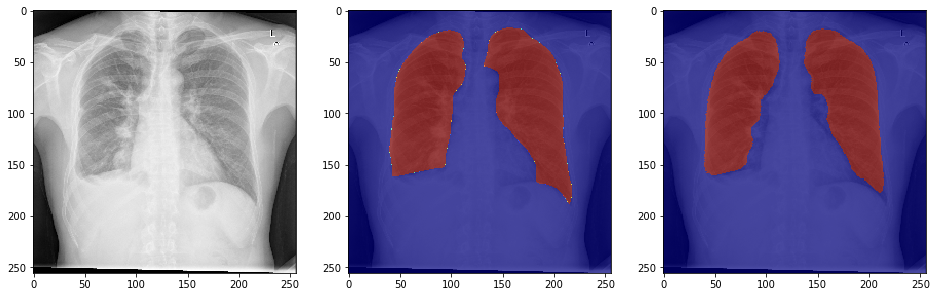

In [63]:
for test_img, test_mask, res_mask in zip(test_images, test_masks, res):
  test_img = array_to_img(test_img)
  test_mask = array_to_img(test_mask)
  res_mask = array_to_img(res_mask > 0.5)  # магическое число, убирает некоторые нечеткие области с маски

  plt.figure(figsize=(16, 16))
  
  plt.subplot(1,3,1)
  plt.imshow(test_img, 'gray', interpolation='none')
  
  plt.subplot(1,3,2)
  plt.imshow(test_img, 'gray', interpolation='none')
  plt.imshow(test_mask, 'jet', interpolation='none', alpha=0.7)
  
  plt.subplot(1,3,3)
  plt.imshow(test_img, 'gray', interpolation='none')
  plt.imshow(res_mask, 'jet', interpolation='none', alpha=0.7)
  
  plt.show()